# LLAMA Index

In [78]:
# !pip install -U llama-index
# !pip install --upgrade pydantic
# !pip install llama-index-retrievers-bm25
# !pip install tabulate
# !pip install llama-index-readers-web
# !pip install llama-index-embeddings-huggingface
# !pip install llama-index-vector-stores-faiss
# !pip install llama-index-extractors-entity
# !pip install span-marker==1.5.0



# Data Loading
## SimpleDirectoryReader
A built-in loader that recursively scans a directory for files and loads them into Document objects. Supports .pdf, .txt, .docx, .md, .csv, .json


In [2]:
from llama_index.core import SimpleDirectoryReader

pdf_document = SimpleDirectoryReader(input_files=["data/RAMAYANA.pdf"]).load_data()
print(f"Loaded {len(pdf_document)} document(s).")
print(pdf_document[0].text[:100])  # Preview



Loaded 45 document(s).
SRI RAMA JAYAM 
RAMAYANA FOR CHILDREN 
Compiled by  
 
Visalakshi Gopalan 
14-Apr-13 
 
 
 
For chil


## Custom Loaders

In [3]:
import pandas as pd
from llama_index.core.schema import Document

df = pd.read_csv("data/headcount_2025.csv")
doc_text = df.to_markdown(index=False)

document = Document(text=doc_text, metadata={"source": "headcount_2025.csv"})
print(document.text[:500])  # Preview)


| Name            | Department      | Position                 |   Salary (INR) | 2025 Increase   |
|:----------------|:----------------|:-------------------------|---------------:|:----------------|
| Sarah Verma     | Finance         | Financial Analyst        |         899000 | 11.78%          |
| Aditya Verma    | Sales           | Sales Manager            |         772000 | 10.18%          |
| Vihaan Gupta    | Marketing       | Digital Marketer         |         753000 | 3.7%            |



## Third Party & Web Loaders



In [4]:
from llama_index.readers.web import SimpleWebPageReader

urls = ["https://en.wikipedia.org/wiki/Ramayana"]

# html_to_text=True is recommended for cleaner text extraction
reader = SimpleWebPageReader(html_to_text=True)
documents = reader.load_data(urls)

if documents:
    print(documents[0].text[:500])
    print("\nMetadata:")
    print(documents[0].metadata)
else:
    print("No documents loaded.")

Jump to content

Main menu

Main menu

move to sidebar hide

Navigation

  * [Main page](/wiki/Main_Page "Visit the main page \[z\]")
  * [Contents](/wiki/Wikipedia:Contents "Guides to browsing Wikipedia")
  * [Current events](/wiki/Portal:Current_events "Articles related to current events")
  * [Random article](/wiki/Special:Random "Visit a randomly selected article \[x\]")
  * [About Wikipedia](/wiki/Wikipedia:About "Learn about Wikipedia and how it works")
  * [Contact us](//en.wikipedia.org/

Metadata:
{}


## Data Chunking
### Default Chunking (FIxed Chunking)


In [5]:
from llama_index.core.node_parser import SimpleNodeParser 

parser = SimpleNodeParser.from_defaults(chunk_size=512)
nodes = parser.get_nodes_from_documents(pdf_document)

for idx, node in enumerate(nodes[:2]):
    print(f"Chunk {idx+1}\n Chunk Text:{node.text}")

Chunk 1
 Chunk Text:SRI RAMA JAYAM 
RAMAYANA FOR CHILDREN 
Compiled by  
 
Visalakshi Gopalan 
14-Apr-13 
 
 
 
For children’s reading
Chunk 2
 Chunk Text:1 
 
Contents 
 
1 RAMAYANA FOR CHILDREN ............................................................................................... 2 
1.1 THE BIRTH OF RAMA ..................................................................................................... 2 
1.2 The Valiant Princes ........................................................................................................ 3 
1.3 SITA'S SWAYAMVAR ..................................................................................................... 5 
1.4 KAIKEYI AND HER WISHES ....................................................................................... 7 
1.5 The demons in the forests ........................................................................................ 20 
1.6 The Kidnapping of Sita ....................................................

## Data Chunking
### RecursiveTextSplitter


In [6]:
from llama_index.core.node_parser import LangchainNodeParser
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
parser = LangchainNodeParser(lc_splitter=text_splitter)

nodes = parser.get_nodes_from_documents(pdf_document)

for idx, node in enumerate(nodes[:2]):
    print(f"Chunk {idx+1}\n Chunk Text:{node.text}")

Chunk 1
 Chunk Text:SRI RAMA JAYAM 
RAMAYANA FOR CHILDREN 
Compiled by  
 
Visalakshi Gopalan 
14-Apr-13 
 
 
 
For children’s reading
Chunk 2
 Chunk Text:1 
 
Contents 
 
1 RAMAYANA FOR CHILDREN ............................................................................................... 2 
1.1 THE BIRTH OF RAMA ..................................................................................................... 2 
1.2 The Valiant Princes ........................................................................................................ 3


## Data Chunking
### SemanticSplitterNodeParser



In [7]:
from llama_index.core.node_parser import SemanticSplitterNodeParser
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

embed_model = HuggingFaceEmbedding(model_name="all-MiniLM-L6-v2", device="cpu")
parser = SemanticSplitterNodeParser(embed_model=embed_model, chunk_size=512)

nodes = parser.get_nodes_from_documents(pdf_document)

for idx, node in enumerate(nodes[:2]):
    print(f"Chunk {idx+1}\n Chunk Text:{node.text}")

/home/avinash/Desktop/dr_avinash/generative_ai/lecture-8/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Chunk 1
 Chunk Text:SRI RAMA JAYAM 
RAMAYANA FOR CHILDREN 
Compiled by  
 
Visalakshi Gopalan 
14-Apr-13 
 
 
 
For children’s reading 
Chunk 2
 Chunk Text:1 
 
Contents 
 
1 RAMAYANA FOR CHILDREN ............................................................................................... 2 
1.1 THE BIRTH OF RAMA ..................................................................................................... 2 
1.2 The Valiant Princes ........................................................................................................ 3 
1.3 SITA'S SWAYAMVAR ..................................................................................................... 5 
1.4 KAIKEYI AND HER WISHES ....................................................................................... 7 
1.5 The demons in the forests ........................................................................................ 20 
1.6 The Kidnapping of Sita ...................................................

## Data Chunking
### Graph-Based Chunking


In [8]:
from llama_index.core.node_parser import SimpleNodeParser

parser = SimpleNodeParser.from_defaults(chunk_size=1024)
nodes = parser.get_nodes_from_documents(pdf_document)

import spacy

nlp = spacy.load("en_core_web_sm")  # Use a larger model if needed

node_entity_map = {}

for node in nodes:
    doc = nlp(node.text)
    entities = list(set([ent.text.strip() for ent in doc.ents if ent.label_ in ("PERSON", "ORG", "GPE", "LOC")]))
    node_entity_map[node.node_id] = {"text": node.text, "entities": entities}



import networkx as nx
from collections import defaultdict

G = nx.Graph()
entity_chunk_map = defaultdict(list)

for node_id, data in node_entity_map.items():
    text = data["text"]
    entities = data["entities"]

    # Add entities and connect co-occurrences
    for i in range(len(entities)):
        entity_chunk_map[entities[i]].append((node_id, text))
        for j in range(i + 1, len(entities)):
            G.add_edge(entities[i], entities[j])




In [9]:
chunks = []
visited = set()

for entity in G.nodes():
    if entity not in visited:
        component = nx.node_connected_component(G, entity)
        visited.update(component)

        combined_texts = []
        for e in component:
            combined_texts.extend([text for _, text in entity_chunk_map[e]])

        combined_chunk = "\n".join(set(combined_texts))
        chunks.append(combined_chunk)

# Preview the chunks
for i, chunk in enumerate(chunks[:2]):
    print(f"--- Chunk {i+1} ---\n{chunk[:500]}...\n")


--- Chunk 1 ---
20 
 
knowledge of your ministers with you. And the responsibility of 
ruling over Ayodhya is yours. Go back and rule over it well.” 
With no other option Bharatha said “Brother, I will rule over 
Ayodhya on your behalf. So please give me your sandals. I will place 
them on the throne.” Rama agreed to this, speaking again Bharatha 
swore “I hereby take an oath that I shall await your return and for 
this period of fourteen years I shall not wear any royal clothes and I 
shall subsist only on fru...



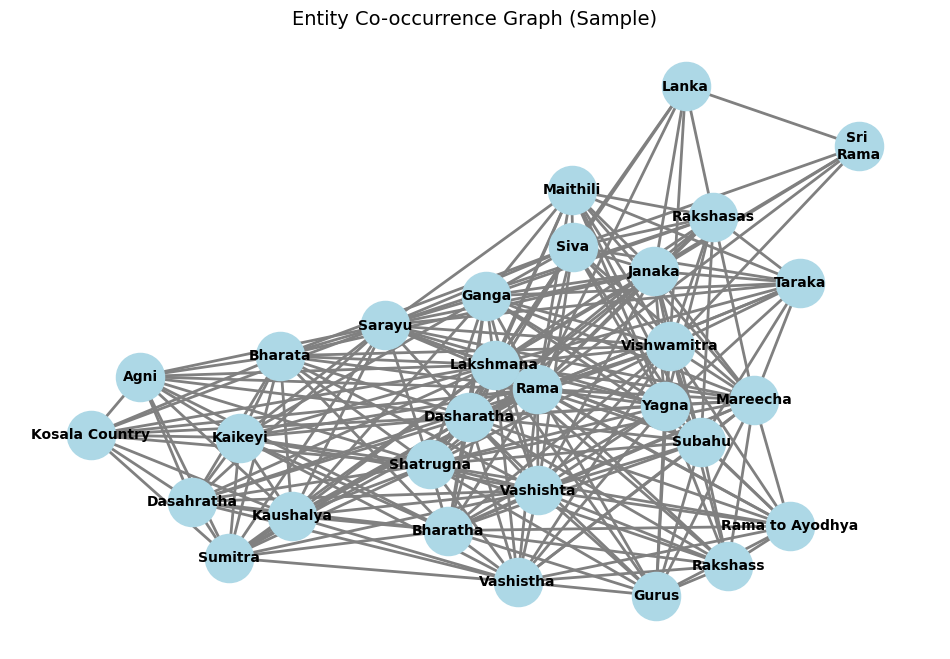

In [10]:
import matplotlib.pyplot as plt

# Optionally limit to top N entities to avoid clutter
top_entities = list(G.nodes)[:30]
subgraph = G.subgraph(top_entities)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, seed=42)

nx.draw_networkx_nodes(subgraph, pos, node_color='lightblue', node_size=1200)
nx.draw_networkx_edges(subgraph, pos, width=2, edge_color='gray')
nx.draw_networkx_labels(subgraph, pos, font_size=10, font_weight='bold')

plt.title("Entity Co-occurrence Graph (Sample)", fontsize=14)
plt.axis('off')
plt.show()


## Embedding and Vector Stores

In [11]:
from llama_index.core import VectorStoreIndex
from llama_index.vector_stores.faiss import FaissVectorStore
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
import faiss

EMBEDDING_DIM = 384
embed_model = HuggingFaceEmbedding(model_name="all-MiniLM-L6-v2", device="cpu")

faiss_index = faiss.IndexFlatL2(EMBEDDING_DIM)
vector_store = FaissVectorStore(faiss_index=faiss_index)

index = VectorStoreIndex(
    nodes=nodes,
    vector_store=vector_store,
    embed_model=embed_model,
)

query_engine = index.as_query_engine()
response = query_engine.query("What is the role of Rama in Ramayana?")
print(response)



Rama plays a central role in the Ramayana as the protagonist and hero of the epic. He is depicted as an ideal king, husband, and son, embodying virtues such as righteousness, devotion, and courage. Rama's journey, from being crowned the king of Ayodhya to his exile in the forest, his search for Sita, and the eventual battle against Ravana, showcases his unwavering commitment to dharma and his willingness to sacrifice personal happiness for the greater good. Throughout the epic, Rama's character serves as a moral compass, inspiring readers to follow his ideals of truth, duty, and compassion.


In [43]:
pages = []
for item in response.metadata.items():
    pages.append(item[1]['page_label'])

print("The Answer is taken from Page:", ", ".join(pages))
print("🧠 Answer:\n", '\n'.join([''.join(response.response[i:i + 70]) for i in range(0, len(response.response), 70)]))

The Answer is taken from Page: 45, 29
🧠 Answer:
 Rama plays a central role in the Ramayana as the protagonist and hero 
of the epic. He is depicted as an ideal king, husband, and son, embody
ing virtues such as righteousness, devotion, and courage. Rama's journ
ey, from being crowned the king of Ayodhya to his exile in the forest,
 his search for Sita, and the eventual battle against Ravana, showcase
s his unwavering commitment to dharma and his willingness to sacrifice
 personal happiness for the greater good. Throughout the epic, Rama's 
character serves as a moral compass, inspiring readers to follow his i
deals of truth, duty, and compassion.


## Choose the right Index
### VectorStorIndex - Semantic Search

In [48]:
from llama_index.core import VectorStoreIndex
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

embed_model = HuggingFaceEmbedding(model_name="all-MiniLM-L6-v2", device="cpu")
index = VectorStoreIndex.from_documents(pdf_document, embed_model=embed_model)

query_engine = index.as_query_engine()
response = query_engine.query("What values does Ramayana teach?")
print("🧠 Answer:\n", '\n'.join([''.join(response.response[i:i + 70]) for i in range(0, len(response.response), 70)]))


🧠 Answer:
 Ramayana teaches values such as devotion towards parents, ideal behavi
or as a king, respect for all individuals, ruling a kingdom well, trut
hfulness, and being virtuous and valiant.


## Choose the right Index
### KeywordTableIndex – Exact Match Search


In [ ]:
from llama_index.core import KeywordTableIndex

index = KeywordTableIndex.from_documents(documents)

query_engine = index.as_query_engine()
response = query_engine.query("Mentions of Ayodhya and Lanka")

print("🧠 Answer:\n", '\n'.join([''.join(response.response[i:i + 70]) for i in range(0, len(response.response), 70)]))



🧠 Answer:
 The epic _Ramayana_ narrates the life of Rama, a prince of Ayodhya in 
the kingdom of Kosala, and his eventual return to Ayodhya to be crowne
d as a king. It also includes the kidnapping of Sita by Ravana, the ki
ng of Lanka.


## Choose the right Index
### ListIndex – Sequential Answering


In [ ]:
from llama_index.core import ListIndex

index = ListIndex.from_documents(documents)

query_engine = index.as_query_engine()
response = query_engine.query("Give me a summary chapter by chapter")

print("🧠 Answer:\n", '\n'.join([''.join(response.response[i:i + 70]) for i in range(0, len(response.response), 70)]))


🧠 Answer:
 The epic "Ramayana" is divided into seven main chapters, known as Kand
as. The chapters are as follows:

1. Bāla Kāṇḍa
2. Ayodhyā Kāṇḍa
3. Ar
aṇya Kāṇḍa
4. Kiṣkindhā Kāṇḍa
5. Sundara Kāṇḍa
6. Yuddha Kāṇḍa
7. Utta
ra Kanda

Each chapter focuses on different aspects of the story of Lo
rd Rama, his wife Sita, and his loyal companion Hanuman, as they navig
ate through various challenges and adventures.


# Advanced Retrieval with Filters & Hybrid Search
## Metadata Filtering

In [68]:
from llama_index.core import SimpleDirectoryReader, VectorStoreIndex
from llama_index.core.node_parser import SimpleNodeParser

# Load documents and tag metadata
documents = SimpleDirectoryReader(input_files=["data/RAMAYANA.pdf"]).load_data()
for doc in documents:
    doc.metadata = {"source": "Ramayana", "location": "Ayodhya" if "Ayodhya" in doc.text else "Other"}

# Create index
index = VectorStoreIndex.from_documents(documents)




In [73]:
from llama_index.core.vector_stores.types import MetadataFilters, MetadataFilter
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.query_engine import RetrieverQueryEngine

# Build filters using MetadataFilter and MetadataFilters
filters = MetadataFilters(
    filters=[MetadataFilter(key="location", value="Ayodhya")]
)

retriever = VectorIndexRetriever(index=index, filters=filters)
query_engine = RetrieverQueryEngine(retriever=retriever)
response = query_engine.query("Who ruled Ayodhya?")
print("🧠 Answer:\n", '\n'.join([''.join(response.response[i:i + 70]) for i in range(0, len(response.response), 70)]))

🧠 Answer:
 Bharatha ruled Ayodhya in place of Rama during Rama's absence.


# Advanced Retrieval with Filters & Hybrid Search
## Hybrid Retrieval (Keyword + Vector Search)

In [ ]:
from llama_index.core.indices.keyword_table import KeywordTableIndex
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.retrievers import QueryFusionRetriever

# Create both vector and keyword indexes
vector_index = VectorStoreIndex.from_documents(documents)
vector_retriever = VectorIndexRetriever(index=vector_index)
keyword_index = KeywordTableIndex.from_documents(documents)
keyword_retriever = keyword_index.as_retriever(similarity_top_k=5)

# hybrid = QueryFusionRetriever([vector_index, keyword_index], mode="reciprocal_rerank", similarity_top_k=5)
hybrid_retriever = QueryFusionRetriever(
    [vector_retriever, keyword_retriever],
    mode="reciprocal_rerank",
    similarity_top_k=5,
    num_queries=4, # Number of synthetic queries to generate
)

query_engine = RetrieverQueryEngine(retriever=hybrid_retriever)
response = query_engine.query("prince of Ayodhya")
print("🧠 Answer:\n", '\n'.join([''.join(response.response[i:i + 70]) for i in range(0, len(response.response), 70)]))

🧠 Answer:
 Rama


# Graph RAG and Entity-Aware Retrieval


In [ ]:
import spacy
import networkx as nx

# Load NLP model for entity extraction
nlp = spacy.load("en_core_web_sm")

# Example text (replace this with your parsed Ramayana chapters)
text = """King Dasharath of Ayodhya had three queens: Kaushalya, Sumitra, and Kaikeyi. 
Ram, the eldest, was born to Kaushalya. He later married the daughter of Janak, Sita, daughter of Janak from Mithila."""

# Step 1: Parse → Extract Entities
doc = nlp(text)
entities = list(set(ent.text for ent in doc.ents if ent.label_ in ["PERSON", "ORG", "GPE", "LOC"]))
print(f"Extracted Entities: {entities}")


# Step 2: Map → Create Node
node = {"text": text, "entities": entities}

# Step 3: Link → Graph Creation
G = nx.Graph()
G.add_node(text, entities=entities)

# Add edges based on entity co-occurrence
for i, e1 in enumerate(entities):
    for e2 in entities[i+1:]:
        G.add_edge(e1, e2, source_text=text)

print(f"📊 Entities: {entities}")
print(f"🔗 Graph edges: {G.edges(data=True)}")


Extracted Entities: ['Kaushalya', 'Ram', 'Sumitra', 'Mithila', 'Janak', 'Dasharath of Ayodhya', 'Kaikeyi']
📊 Entities: ['Kaushalya', 'Ram', 'Sumitra', 'Mithila', 'Janak', 'Dasharath of Ayodhya', 'Kaikeyi']
🔗 Graph edges: [('Kaushalya', 'Ram', {'source_text': 'King Dasharath of Ayodhya had three queens: Kaushalya, Sumitra, and Kaikeyi. \nRam, the eldest, was born to Kaushalya. He later married the daughter of Janak, Sita, daughter of Janak from Mithila.'}), ('Kaushalya', 'Sumitra', {'source_text': 'King Dasharath of Ayodhya had three queens: Kaushalya, Sumitra, and Kaikeyi. \nRam, the eldest, was born to Kaushalya. He later married the daughter of Janak, Sita, daughter of Janak from Mithila.'}), ('Kaushalya', 'Mithila', {'source_text': 'King Dasharath of Ayodhya had three queens: Kaushalya, Sumitra, and Kaikeyi. \nRam, the eldest, was born to Kaushalya. He later married the daughter of Janak, Sita, daughter of Janak from Mithila.'}), ('Kaushalya', 'Janak', {'source_text': 'King Dasharat

# Graph RAG and Entity-Aware Retrieval
## Entity-Aware Retrieval

In [120]:
# Entity-aware retrieval
query_entities = ["Janak", "Mithila"]
matching_nodes = []

for node_text, node_data in G.nodes(data=True):
    entities_in_node = node_data.get("entities", [])

    if all(qe in entities_in_node for qe in query_entities):
            matching_nodes.append(node_text)

for match in matching_nodes:
    print("🔍 Matched Node:\n", match)


🔍 Matched Node:
 King Dasharath of Ayodhya had three queens: Kaushalya, Sumitra, and Kaikeyi. 
Ram, the eldest, was born to Kaushalya. He later married the daughter of Janak, Sita, daughter of Janak from Mithila.


## Full Knowledge Graph based Retrieval

In [121]:
from llama_index.core import VectorStoreIndex

# Create Document with entity metadata
doc = Document(text=text, metadata={"entities": entities})

# Build index and retrieve
index = VectorStoreIndex.from_documents([doc])
retriever = index.as_retriever(similarity_top_k=2)

from llama_index.core.query_engine import RetrieverQueryEngine
query_engine = RetrieverQueryEngine(retriever=retriever)
response = query_engine.query("Who is Janaka?")
print(response)


Janaka is the father of Sita, who is the daughter of Janak from Mithila.


# Memory RAG, Summarization, and History-Aware QA
## Memory RAG

In [128]:
from llama_index.core import SimpleDirectoryReader, VectorStoreIndex
from llama_index.core.memory import ChatMemoryBuffer
from llama_index.core.chat_engine import SimpleChatEngine

# Load Ramayana documents
index = VectorStoreIndex.from_documents(pdf_document)

# Create memory buffer
memory = ChatMemoryBuffer.from_defaults(token_limit=1000)

# ✅ Use SimpleChatEngine instead of RetrieverQueryEngine
chat_engine = SimpleChatEngine.from_defaults(
    retriever=index.as_retriever(),
    memory=memory
)

# Simulate multi-turn conversation
print("User: Who is Rama?")
response1 = chat_engine.chat("Who is Rama?")
print("AI:", response1.response)

print("\nUser: Who is his wife?")
response2 = chat_engine.chat("Who is his wife?")
print("AI:", response2.response)

# ✅ Print stored memory
print("\n🧠 Stored Memory:")
for i, msg in enumerate(memory.get(), 1):
    role = msg.role.value.capitalize()
    content = msg.blocks[0].text if msg.blocks else "(No text)"
    print(f"Turn {i}: {role}: {content}")


User: Who is Rama?
AI: Rama is a major deity in Hinduism, who is considered to be the seventh avatar of the god Vishnu. He is a central figure in the Hindu epic, the Ramayana, which tells the story of his adventures and his battle against the demon king Ravana to rescue his wife Sita. Rama is revered as a symbol of virtue, righteousness, and dharma (duty).

User: Who is his wife?
AI: Rama's wife is Sita. She is also a central figure in the Hindu epic, the Ramayana. Sita is known for her devotion, purity, and loyalty to Rama. She is considered to be an ideal wife and is revered as a symbol of femininity, strength, and sacrifice in Hindu mythology.

🧠 Stored Memory:
Turn 1: User: Who is Rama?
Turn 2: Assistant: Rama is a major deity in Hinduism, who is considered to be the seventh avatar of the god Vishnu. He is a central figure in the Hindu epic, the Ramayana, which tells the story of his adventures and his battle against the demon king Ravana to rescue his wife Sita. Rama is revered as

# LlamaIndex + LangChain + LangGraph

In [133]:
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader
from langchain_core.runnables import RunnableLambda
from dataclasses import dataclass
from langgraph.graph import StateGraph

# Step 1: Load and index documents
# For demonstration, let's create a dummy index if pdf_document is not available
index = VectorStoreIndex.from_documents(pdf_document, embed_model=embed_model)

# Step 2: Create a retriever or query engine
query_engine = index.as_query_engine()

@dataclass
class QAState:
    question: str
    result: str = "" # Initialize result to an empty string

graph = StateGraph(QAState)

def llama_query_node(state: QAState): # Type hint for clarity
    response = query_engine.query(state.question)
    return {"result": str(response)}

llama_node = RunnableLambda(llama_query_node)

# Add nodes and flow as before
graph.add_node("retrieve_info", llama_node)
graph.set_entry_point("retrieve_info")
graph.set_finish_point("retrieve_info")

retrieval_graph = graph.compile()
output = retrieval_graph.invoke({"question": "Who is Rama's wife?", "result": ""})
print(output["result"])

Sita


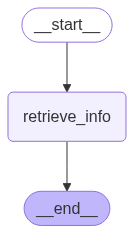

In [134]:
from IPython.display import Image, display

graph_image_data = retrieval_graph.get_graph().draw_mermaid_png()
display(Image(graph_image_data))

# Custom Data Flow Graphs

In [8]:
from llama_index.core import Document, VectorStoreIndex, Settings
from llama_index.llms.openai import OpenAI
from llama_index.core.query_engine import CustomQueryEngine

# 1. Prepare a list of short texts
sample_texts = [
    "Rama is the prince of Ayodhya and known for his righteousness.",
    "Sita is Rama's wife, revered for her devotion and purity.",
    "Ravana abducted Sita, leading to a great war in Lanka.",
    "Hanuman, the monkey devotee, played a key role in rescuing Sita."
]
documents = [Document(text=t) for t in sample_texts]

# 2. Configure global settings with your LLM (replace OpenAI with your preferred LLM if needed)
Settings.llm = OpenAI(temperature=0)

# 3. Build index from raw text
index = VectorStoreIndex.from_documents(documents)

# 4. Summarizer engine
summarizer_engine = index.as_query_engine(response_mode="tree_summarize")

# 5. Critique engine using custom LLM prompt
class CritiqueEngine(CustomQueryEngine):
    def custom_query(self, query_str: str):
        prompt = f"""Summarized Input:
{query_str}

Write a thoughtful critique focusing on the emotional depth and themes involved."""
        return Settings.llm.complete(prompt).text

critique_engine = CritiqueEngine()

# 6. Graph-style pipeline function
def simple_graph_pipeline(query):
    print("🔍 Query:", query)
    
    retrieved = index.as_query_engine(similarity_top_k=3).query(query)
    print("\n📚 Retrieved Text:\n", retrieved)

    summarized = summarizer_engine.query(query)
    print("\n📝 Summary:\n", summarized)

    critique = critique_engine.query(str(summarized))
    print("\n🧠 Critique:\n", critique)

# 7. Execute
simple_graph_pipeline("What happened to Sita in the Ramayana?")


🔍 Query: What happened to Sita in the Ramayana?

📚 Retrieved Text:
 Sita was abducted by Ravana in the Ramayana.

📝 Summary:
 Sita was rescued by Hanuman, the monkey devotee, in the Ramayana.

🧠 Critique:
 The rescue of Sita by Hanuman in the Ramayana is a powerful moment that delves into themes of loyalty, devotion, and sacrifice. Hanuman's unwavering dedication to Lord Rama and his willingness to go to great lengths to rescue Sita showcases the depth of his emotional connection to his beloved deity. The act of rescuing Sita also highlights the importance of standing up for what is right and protecting those who are vulnerable, even in the face of great adversity. Overall, this moment in the Ramayana serves as a poignant reminder of the power of love, faith, and selflessness in overcoming obstacles and achieving justice.


In [5]:
import llama_index
import importlib.metadata
print(importlib.metadata.version("llama-index"))

# List attributes in graph_stores
import llama_index.core.graph_stores as gs
print(dir(gs))

0.12.42
['ChunkNode', 'EntityNode', 'LabelledNode', 'PropertyGraphStore', 'Relation', 'SimpleGraphStore', 'SimplePropertyGraphStore', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'prompts', 'simple', 'simple_labelled', 'types']
